# Predictive Analytics ICW Notebook

Candidate Number: FZHL1

# Table of Contents
* [Setup](#A)
* [Getting the Data](#B)
* [Exploring the Data](#C)
* [Data Preparation](#D)
* [Training the Model](#E)
* [Fine-Tuning](#F)
* [Checking Individual Predictions](#G)
* [Extra](#H)

# Setup <a class="anchor" id="A"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import xception, resnet50, vgg16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_xception
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import requests
from tqdm import tqdm
from PIL import Image
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

2024-04-18 05:05:28.295227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Getting the Data <a class="anchor" id="B"></a>

## Loading and Merging the Datasets

The merged dataset is provided in Onedrive

In [3]:
# # Loading the required datasets
# # df_images contains URLs for the artworks from which the images will be loaded
# # df_all contains emotion data, which will be used for emotion labels for the images
# df_images = pd.read_csv('WikiArt-info.csv')
# df_all = pd.read_csv('WikiArt-Emotions-All.tsv', sep='\t')

# # Merging the Dataframes using artwork 'ID' 
# df = pd.merge(df_images, df_all, on='ID')

In [4]:
# df.to_csv('WikiArt_Emotions.csv', index=False)

In [2]:
df = pd.read_csv('WikiArt_Emotions.csv')

## Loading Images from URLS

These are already preloaded and submitted in the Onedrive folder

In [3]:
# # Defining a function to open the URLs to allow downloading
# def download_image(url, filename):
#     response = requests.get(url)
#     if response.status_code == 200:
#         with open(filename, 'wb') as f:
#             f.write(response.content)

# # Downloading images into a local file to retrieve later for training the model. 
# # Each image is labelled with its respective 'ID' as the filename
# for index, row in tqdm(df_combined.iterrows(), total=df_combined.shape[0]):
#     image_url = row['Image URL']
#     image_path = f'{All Images/row["ID"]}.jpg'
#     download_image(image_url, image_path)

# Exploring the Data <a class="anchor" id="C"></a>

## Descriptive Statistics

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,ID,Category_x,Artist_x,Title_x,Year_x,Image URL,Painting Info URL,Artist Info URL,Style,Category_y,Artist_y,Title_y,Year_y,Is painting,Face/body,Ave. art rating,Art (image+title): agreeableness,Art (image+title): anger,Art (image+title): anticipation,Art (image+title): arrogance,Art (image+title): disagreeableness,Art (image+title): disgust,Art (image+title): fear,Art (image+title): gratitude,Art (image+title): happiness,Art (image+title): humility,Art (image+title): love,Art (image+title): optimism,Art (image+title): pessimism,Art (image+title): regret,Art (image+title): sadness,Art (image+title): shame,Art (image+title): shyness,Art (image+title): surprise,Art (image+title): trust,Art (image+title): neutral,ImageOnly: agreeableness,ImageOnly: anger,ImageOnly: anticipation,ImageOnly: arrogance,ImageOnly: disagreeableness,ImageOnly: disgust,ImageOnly: fear,ImageOnly: gratitude,ImageOnly: happiness,ImageOnly: humility,ImageOnly: love,ImageOnly: optimism,ImageOnly: pessimism,ImageOnly: regret,ImageOnly: sadness,ImageOnly: shame,ImageOnly: shyness,ImageOnly: surprise,ImageOnly: trust,ImageOnly: neutral,TitleOnly: agreeableness,TitleOnly: anger,TitleOnly: anticipation,TitleOnly: arrogance,TitleOnly: disagreeableness,TitleOnly: disgust,TitleOnly: fear,TitleOnly: gratitude,TitleOnly: happiness,TitleOnly: humility,TitleOnly: love,TitleOnly: optimism,TitleOnly: pessimism,TitleOnly: regret,TitleOnly: sadness,TitleOnly: shame,TitleOnly: shyness,TitleOnly: surprise,TitleOnly: trust,TitleOnly: neutral
0,58c6237dedc2c9c7dc0de1ae,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,1889,https://uploads3.wikiart.org/00123/images/char...,https://www.wikiart.org/en/charles-courtney-cu...,https://www.wikiart.org/en/charles-courtney-cu...,Modern Art,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,1889,yes,face,2.33,0.036,0.012,0.071,0.012,0.012,0.000,0.036,0.131,0.750,0.357,0.357,0.333,0.048,0.024,0.131,0.000,0.012,0.048,0.274,0.0,0.060,0.012,0.071,0.024,0.012,0.000,0.012,0.119,0.726,0.369,0.250,0.274,0.012,0.000,0.131,0.000,0.024,0.024,0.250,0.0,0.060,0.012,0.179,0.000,0.012,0.012,0.000,0.107,0.714,0.190,0.155,0.238,0.024,0.012,0.024,0.012,0.000,0.048,0.155,0.0
1,577280dfedc2cb3880f28e76,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,1984,https://uploads1.wikiart.org/images/keith-hari...,https://www.wikiart.org/en/keith-haring/the-ma...,https://www.wikiart.org/en/keith-haring,Modern Art,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,1984,yes,body,0.70,0.000,0.000,0.500,0.000,0.400,0.100,0.300,0.000,0.100,0.000,0.100,0.100,0.200,0.100,0.100,0.000,0.000,0.500,0.100,0.0,0.000,0.000,0.100,0.000,0.000,0.100,0.300,0.000,0.100,0.100,0.000,0.200,0.200,0.100,0.200,0.000,0.000,0.500,0.000,0.0,0.000,0.000,0.600,0.000,0.300,0.000,0.200,0.000,0.300,0.000,0.200,0.000,0.100,0.000,0.000,0.000,0.000,0.200,0.000,0.0
2,57727f2dedc2cb3880ed5fa9,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,1906,https://uploads3.wikiart.org/images/j-zsef-rip...,https://www.wikiart.org/en/jozsef-rippl-ronai/...,https://www.wikiart.org/en/jozsef-rippl-ronai,Modern Art,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,1906,yes,face,1.60,0.000,0.000,0.200,0.000,0.000,0.000,0.000,0.000,0.500,0.500,0.000,0.300,0.000,0.000,0.000,0.000,0.000,0.100,0.300,0.0,0.000,0.000,0.200,0.000,0.000,0.000,0.000,0.100,0.500,0.300,0.000,0.300,0.000,0.000,0.000,0.000,0.000,0.100,0.200,0.0,0.000,0.000,0.600,0.000,0.000,0.000,0.000,0.000,0.200,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.100,0.0
3,58d1240cedc2c94f900fc610,Cubism,Vadym Meller,Monk. For the Play &#39;Mazeppa&#39;,1920,https://uploads2.wikiart.org/00124/images/vady...,https://www.wikiart.org/en/vadym-meller/monk-f...,https://www.wikiart.org/en/vadym-meller,Modern Art,Cubism,Vadym Meller,Monk. For the Play &#39;Mazeppa&#39;,1920,yes,face,0.82,0.000,0.000,0.091,0.000,0.000,0.091,0.091,0.000,0.091,0.182,0.00

In [4]:
total_artworks = df['ID'].nunique()
total_artworks

4105

In [5]:
artwork_styles_count = df['Style'].value_counts()
artwork_styles_count

Modern Art                         2502
Post Renaissance Art                987
Renaissance Art                     415
Contemporary Art                    193
Contemporary Art,Modern Art           7
Modern Art,Post Renaissance Art       1
Name: Style, dtype: int64

In [6]:
total_artists = df['Artist_x'].nunique()
total_artists

1001

In [7]:
emotion_columns = [col for col in df.columns if 'ImageOnly' in col]
number_of_emotions = len(emotion_columns)

number_of_emotions

20

## Visualizations

Top emotions were extracted from the emotion columns. These were emotions that had the highest probability of being associated with each artwork image. 

Then, to simplify the prediction, emotions are divided into three broad categories: positive emotions, negative emotions, and neutral emotions.

In [3]:
# Extracting the top emotions. These are emotions with the highest probability of occurance for each piece. 
emotion_columns = [col for col in df.columns if col.startswith('ImageOnly')]
df['top_emotion'] = df[emotion_columns].idxmax(axis=1).apply(lambda x: x.split(': ')[1])

In [4]:
# Reducing the top emotions to only three emotion categories: positive, neutral, and negative.
emotion_mapping = {
    'positive': ['agreeableness', 'anticipation', 'gratitude', 'happiness', 'love', 'optimism', 'trust'],
    'negative': ['anger', 'arrogance', 'disagreeableness', 'disgust', 'fear', 'pessimism', 'regret', 'sadness', 'shame'],
    'neutral': ['surprise', 'neutral', 'shyness', 'humility']
}
df['emotion_category'] = df['top_emotion'].apply(lambda x: next((k for k, v in emotion_mapping.items() if x in v), 'neutral'))

In [10]:
df.head()

,ID,Category_x,Artist_x,Title_x,Year_x,Image URL,Painting Info URL,Artist Info URL,Style,Category_y,Artist_y,Title_y,Year_y,Is painting,Face/body,Ave. art rating,Art (image+title): agreeableness,Art (image+title): anger,Art (image+title): anticipation,Art (image+title): arrogance,Art (image+title): disagreeableness,Art (image+title): disgust,Art (image+title): fear,Art (image+title): gratitude,Art (image+title): happiness,Art (image+title): humility,Art (image+title): love,Art (image+title): optimism,Art (image+title): pessimism,Art (image+title): regret,Art (image+title): sadness,Art (image+title): shame,Art (image+title): shyness,Art (image+title): surprise,Art (image+title): trust,Art (image+title): neutral,ImageOnly: agreeableness,ImageOnly: anger,ImageOnly: anticipation,ImageOnly: arrogance,ImageOnly: disagreeableness,ImageOnly: disgust,ImageOnly: fear,ImageOnly: gratitude,ImageOnly: happiness,ImageOnly: humility,ImageOnly: love,ImageOnly: optimism,ImageOnly: pessimism,ImageOnly: regret,ImageOnly: sadness,ImageOnly: shame,ImageOnly: shyness,ImageOnly: surprise,ImageOnly: trust,ImageOnly: neutral,TitleOnly: agreeableness,TitleOnly: anger,TitleOnly: anticipation,TitleOnly: arrogance,TitleOnly: disagreeableness,TitleOnly: disgust,TitleOnly: fear,TitleOnly: gratitude,TitleOnly: happiness,TitleOnly: humility,TitleOnly: love,TitleOnly: optimism,TitleOnly: pessimism,TitleOnly: regret,TitleOnly: sadness,TitleOnly: shame,TitleOnly: shyness,TitleOnly: surprise,TitleOnly: trust,TitleOnly: neutral,top_emotion,emotion_category
0,58c6237dedc2c9c7dc0de1ae,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,1889,https://uploads3.wikiart.org/00123/images/char...,https://www.wikiart.org/en/charles-courtney-cu...,https://www.wikiart.org/en/charles-courtney-cu...,Modern Art,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,1889,yes,face,2.33,0.036,0.012,0.071,0.012,0.012,0.000,0.036,0.131,0.750,0.357,0.357,0.333,0.048,0.024,0.131,0.000,0.012,0.048,0.274,0.0,0.060,0.012,0.071,0.024,0.012,0.000,0.012,0.119,0.726,0.369,0.250,0.274,0.012,0.000,0.131,0.000,0.024,0.024,0.250,0.0,0.060,0.012,0.179,0.000,0.012,0.012,0.000,0.107,0.714,0.190,0.155,0.238,0.024,0.012,0.024,0.012,0.000,0.048,0.155,0.0,happiness,positive
1,577280dfedc2cb3880f28e76,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,1984,https://uploads1.wikiart.org/images/keith-hari...,https://www.wikiart.org/en/keith-haring/the-ma...,https://www.wikiart.org/en/keith-haring,Modern Art,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,1984,yes,body,0.70,0.000,0.000,0.500,0.000,0.400,0.100,0.300,0.000,0.100,0.000,0.100,0.100,0.200,0.100,0.100,0.000,0.000,0.500,0.100,0.0,0.000,0.000,0.100,0.000,0.000,0.100,0.300,0.000,0.100,0.100,0.000,0.200,0.200,0.100,0.200,0.000,0.000,0.500,0.000,0.0,0.000,0.000,0.600,0.000,0.300,0.000,0.200,0.000,0.300,0.000,0.200,0.000,0.100,0.000,0.000,0.000,0.000,0.200,0.000,0.0,surprise,neutral
2,57727f2dedc2cb3880ed5fa9,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,1906,https://uploads3.wikiart.org/images/j-zsef-rip...,https://www.wikiart.org/en/jozsef-rippl-ronai/...,https://www.wikiart.org/en/jozsef-rippl-ronai,Modern Art,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,1906,yes,face,1.60,0.000,0.000,0.200,0.000,0.000,0.000,0.000,0.000,0.500,0.500,0.000,0.300,0.000,0.000,0.000,0.000,0.000,0.100,0.300,0.0,0.000,0.000,0.200,0.000,0.000,0.000,0.000,0.100,0.500,0.300,0.000,0.300,0.000,0.000,0.000,0.000,0.000,0.100,0.200,0.0,0.000,0.000,0.600,0.000,0.000,0.000,0.000,0.000,0.200,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.100,0.0,happiness,positive
3,58d1240cedc2c94f900fc610,Cubism,Vadym Meller,Monk. For the Play &#39;Mazeppa&#39;,1920,https://uploads2.wikiart.org/00124/images/vady...,https://www.wikiart.org/en/vadym-meller/monk-f...,https://www.wikiart.org/en/vadym-meller,Modern Art,Cubism,Vadym Meller,Monk. For the Play &#39;Mazeppa&#39;

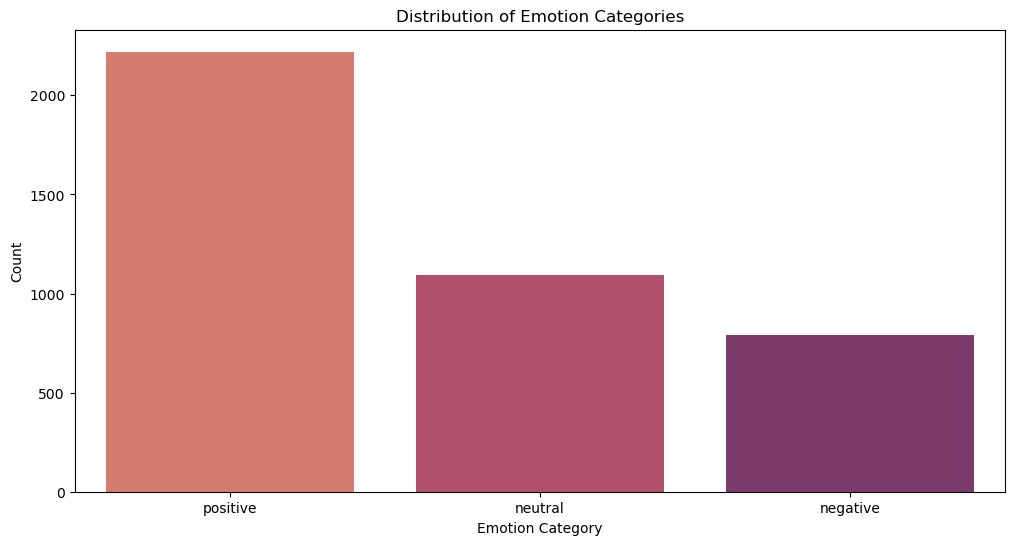

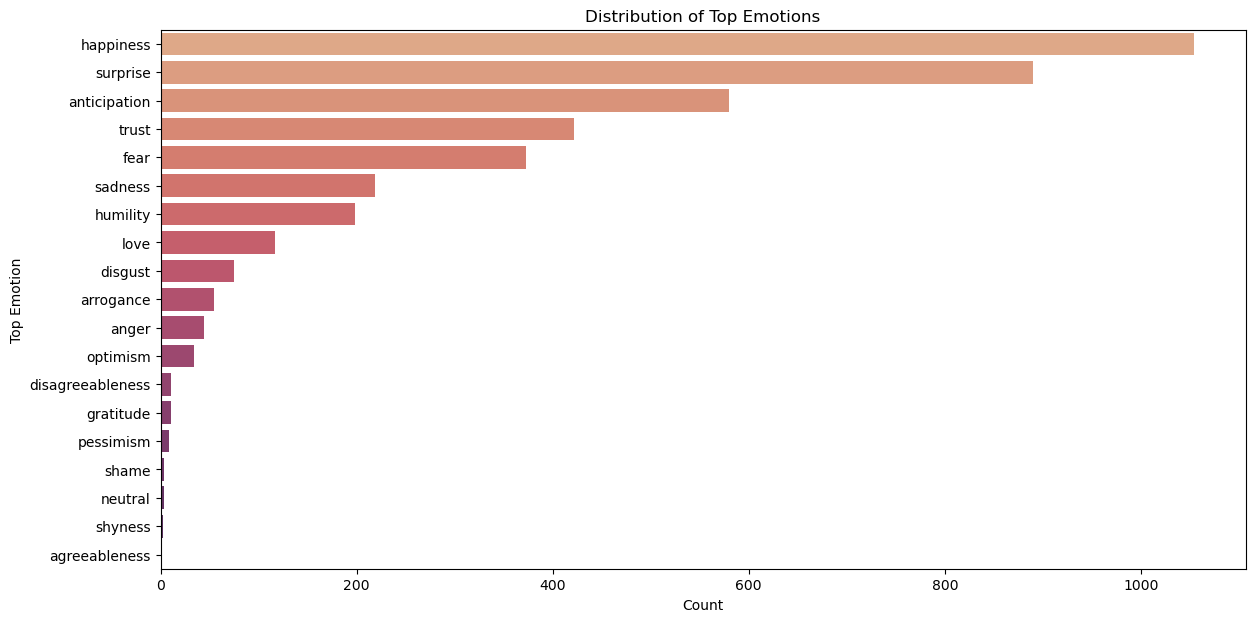

In [12]:
plt.figure(figsize=(12, 6))

# Creating a count plot for the three emotion categories
sns.countplot(x='emotion_category', data=df, palette='flare')
plt.title('Distribution of Emotion Categories')
plt.xlabel('Emotion Category')
plt.ylabel('Count')
plt.show()

# Creating a countplot for the top emotions
plt.figure(figsize=(14, 7))
sns.countplot(y='top_emotion', data=df, order=df['top_emotion'].value_counts().index, palette='flare')
plt.title('Distribution of Top Emotions')
plt.xlabel('Count')
plt.ylabel('Top Emotion')
plt.show()

/var/folders/47/9j3plv3x3gd1kzmxgfpmr6500000gn/T/ipykernel_16443/2843527951.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  images.show()


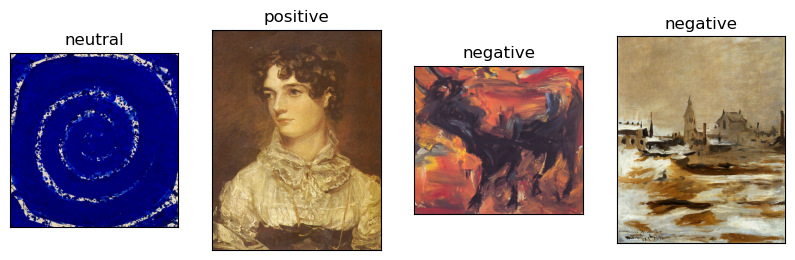

In [14]:
# Viewing some of the images
def generate_image_path(image_id):
    return f'All Images/{image_id}.jpg'

images = plt.figure(figsize=(10, 10))

random = np.random.choice(df.index, size=min(4, len(df)), replace=False)

for i, index in enumerate(random):
    row = df.loc[index]
    path = generate_image_path(row['ID'])
    pic = np.array(Image.open(path))
    plt.subplot(1, 4, i + 1)
    plt.imshow(pic)
    plt.title(row['emotion_category'], size=12)  
    plt.xticks([])
    plt.yticks([])

images.show()

# Data Preparation <a class="anchor" id="D"></a>

## Data Cleaning

Only columns with emotions related to images of the artworks are kept since the objective is to predict emotions based on visual cues.

In [5]:
# Removing irrelevant columns
# In this case, we only use 'ImageOnly' emotions, since we want to classify images based on emotions only
columns_to_remove = [col for col in df.columns if 'TitleOnly' in col or 'Art+Title' in col]
df.drop(columns=columns_to_remove, inplace=True)

In [11]:
df.head()

,ID,Category_x,Artist_x,Title_x,Year_x,Image URL,Painting Info URL,Artist Info URL,Style,Category_y,...,ImageOnly: pessimism,ImageOnly: regret,ImageOnly: sadness,ImageOnly: shame,ImageOnly: shyness,ImageOnly: surprise,ImageOnly: trust,ImageOnly: neutral,top_emotion,emotion_category
0,58c6237dedc2c9c7dc0de1ae,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,1889,https://uploads3.wikiart.org/00123/images/char...,https://www.wikiart.org/en/charles-courtney-cu...,https://www.wikiart.org/en/charles-courtney-cu...,Modern Art,Impressionism,...,0.012,0.000,0.131,0.000,0.024,0.024,0.250,0.0,happiness,positive
1,577280dfedc2cb3880f28e76,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,1984,https://uploads1.wikiart.org/images/keith-hari...,https://www.wikiart.org/en/keith-haring/the-ma...,https://www.wikiart.org/en/keith-haring,Modern Art,Neo-Expressionism,...,0.200,0.100,0.200,0.000,0.000,0.500,0.000,0.0,surprise,neutral
2,57727f2dedc2cb3880ed5fa9,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,1906,https://uploads3.wikiart.org/images/j-zsef-rip...,https://www.wikiart.org/en/jozsef-rippl-ronai/...,https://www.wikiart.org/en/jozsef-rippl-ronai,Modern Art,Post-Impressionism,...,0.000,0.000,0.000,0.000,0.000,0.100,0.200,0.0,happiness,positive
3,58d1240cedc2c94f900fc610,Cubism,Vadym Meller,Monk. For the Play &#39;Mazeppa&#39;,1920,https://uploads2.wikiart.org/00124/images/vady...,https://www.wikiart.org/en/vadym-meller/monk-f...,https://www.wikiart.org/en/vadym-meller,Modern Art,Cubism,...,0.182,0.000,0.364,0.000,0.000,0.273,0.000,0.0,sadness,negative
4,57727de7edc2cb3880e91f26,Romanticism,David Wilkie,The Defence of Sarago&#231;a,1828,https://uploads6.wikiart.org/images/david-wilk...,https://www.wikiart.org/en/david-wilkie/the-de...,https://www.wikiart.org/en/david-wilkie,Post Renaissance Art,Romanticism,...,0.231,0.077,0.231,0.154,0.077,0.154,0.231,0.0,disagreeableness,negative


In [6]:
# Encoding the emotion categories to integers for labelling
label_encoder = LabelEncoder()
emotion_labels_encoded = label_encoder.fit_transform(df['emotion_category'])
emotion_labels_categorical = to_categorical(emotion_labels_encoded)

## Preprocessing Images for VGG16

Preprocessing images for VGG16 requires resizing them to (224, 224).

In [7]:
image_directory = 'All Images'

In [31]:
# Precprocessing images for VGG16 architecture
def preprocess_image_for_vgg(file_path):
    img = image.load_img(file_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_input_vgg16(img_array_expanded_dims)  

preprocessed_images_vgg = [preprocess_image_for_vgg(os.path.join(image_directory, f'{row["ID"]}.jpg')) for index, row in df.iterrows()]
preprocessed_images_vgg = np.vstack(preprocessed_images_vgg)

In [32]:
# Splitting the data into test and training sets, with a training set of 80% and a test size of 20%
X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(preprocessed_images_vgg, emotion_labels_categorical, test_size=0.2, random_state=42)

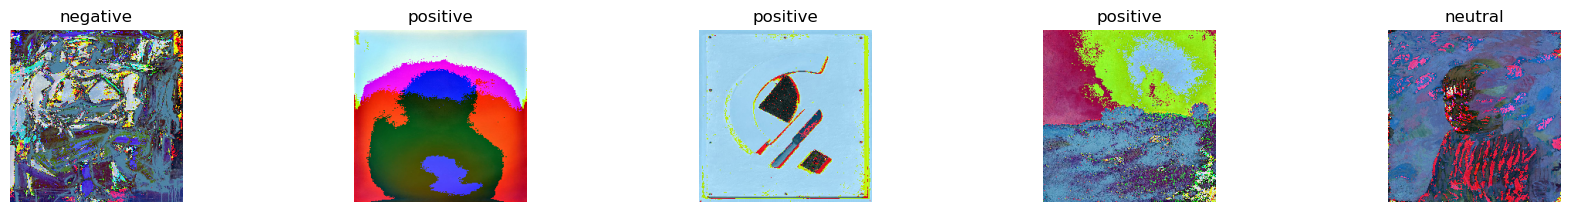

In [18]:
# Displaying preprocessed images along with their emotion labels to confirm the previous steps worked properly

def show_images_with_emotions(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    axes = axes.ravel()

    np.random.seed(42)  
    indices = np.random.randint(0, len(images), size=num_images)
    
    for i, index in enumerate(indices):
        axes[i].imshow(images[index])
        
        # Extracting the emotion label for the respective image
        emotion_label_index = np.argmax(labels[index]) 
        emotion_label = label_encoder.classes_[emotion_label_index]
        
        axes[i].set_title(emotion_label, fontsize=12)
        axes[i].axis('off')

    plt.subplots_adjust(wspace=1)

X_train_display = (X_train_vgg * 255).astype('uint8')
show_images_with_emotions(X_train_display, y_train_vgg, num_images=5)

# Training the Model <a class="anchor" id="E"></a>

The final architecture chosen for the model is VGG16, after comparing performance with Xception and ResNet50.

In [10]:
# Loading the base model, while removing only the top layer
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [17]:
# Adding layers
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  

# Constructing the model
model = Model(inputs=base_model_vgg.input, outputs=predictions)


for layer in base_model_vgg.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model to training sets, with a validation set of 20%
history=model.fit(X_train_vgg, y_train_vgg, epochs=5, validation_split=0.2)

Epoch 1/5
83/83 [==============================] - 394s 5s/step - loss: 2.2787 - accuracy: 0.4979 - val_loss: 1.2430 - val_accuracy: 0.5312
Epoch 2/5
83/83 [==============================] - 409s 5s/step - loss: 0.7569 - accuracy: 0.6768 - val_loss: 1.1557 - val_accuracy: 0.5540
Epoch 3/5
83/83 [==============================] - 346s 4s/step - loss: 0.5254 - accuracy: 0.7941 - val_loss: 1.1890 - val_accuracy: 0.5723
Epoch 4/5
83/83 [==============================] - 335s 4s/step - loss: 0.3550 - accuracy: 0.8645 - val_loss: 1.1852 - val_accuracy: 0.5708
Epoch 5/5
83/83 [==============================] - 332s 4s/step - loss: 0.2144 - accuracy: 0.9391 - val_loss: 1.1958 - val_accuracy: 0.5525


In [18]:
# Evaluating the model on test data
test_loss, test_accuracy = model.evaluate(X_test_vgg, y_test_vgg)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

26/26 [==============================] - 88s 3s/step - loss: 1.1956 - accuracy: 0.5688
Test Loss: 1.1955724954605103
Test Accuracy: 0.5688185095787048


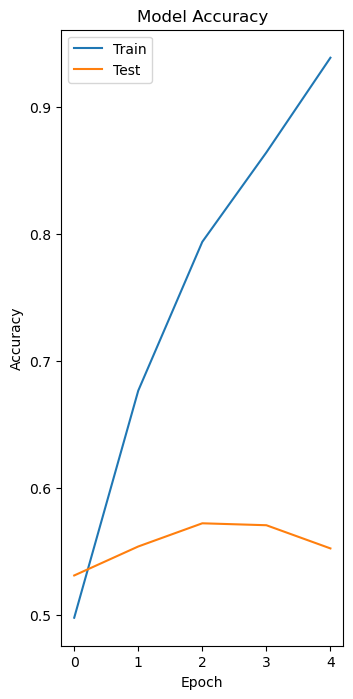

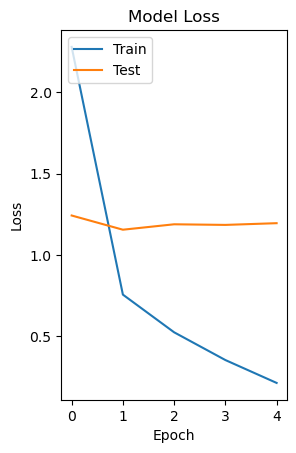

In [19]:
# Plotting training & validation accuracy and loss values
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Fine-Tuning <a class="anchor" id="F"></a>

## Adjusting Dropout

First testing out with a dropout of 0.5 as a base level before lowering the dropout value. 

In [9]:
# Adding a Dropout of 0.5 to start off
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  

model = Model(inputs=base_model_vgg.input, outputs=predictions)

for layer in base_model_vgg.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_vgg, y_train_vgg, epochs=5, validation_split=0.2)

Epoch 1/5
83/83 [==============================] - 365s 4s/step - loss: 2.9272 - accuracy: 0.5006 - val_loss: 1.3064 - val_accuracy: 0.5297
Epoch 2/5
83/83 [==============================] - 368s 4s/step - loss: 1.0623 - accuracy: 0.5908 - val_loss: 1.0737 - val_accuracy: 0.5388
Epoch 3/5
83/83 [==============================] - 370s 4s/step - loss: 0.7885 - accuracy: 0.6662 - val_loss: 1.0076 - val_accuracy: 0.5708
Epoch 4/5
83/83 [==============================] - 365s 4s/step - loss: 0.6218 - accuracy: 0.7400 - val_loss: 1.0137 - val_accuracy: 0.5495
Epoch 5/5
83/83 [==============================] - 406s 5s/step - loss: 0.5791 - accuracy: 0.7568 - val_loss: 1.0594 - val_accuracy: 0.5479


In [10]:
test_loss, test_accuracy = model.evaluate(X_test_vgg, y_test_vgg)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

26/26 [==============================] - 111s 4s/step - loss: 1.0600 - accuracy: 0.5822
Test Loss: 1.0600441694259644
Test Accuracy: 0.5822167992591858


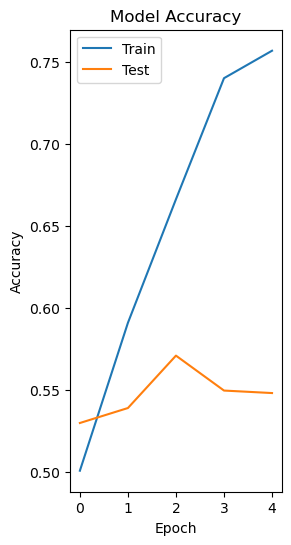

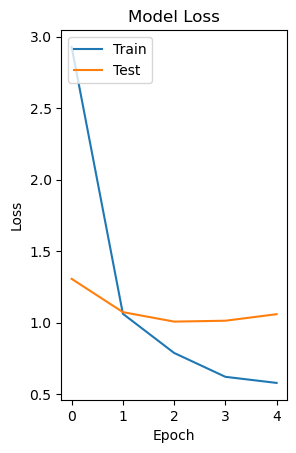

In [15]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Using a lower dropout value of 0.4

In [9]:
# Adding a Dropout of 0.4 instead
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
x = Dropout(0.4)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  

model = Model(inputs=base_model_vgg.input, outputs=predictions)

for layer in base_model_vgg.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_vgg, y_train_vgg, epochs=5, validation_split=0.2)

Epoch 1/5
83/83 [==============================] - 340s 4s/step - loss: 2.4660 - accuracy: 0.4971 - val_loss: 1.6954 - val_accuracy: 0.5510
Epoch 2/5
83/83 [==============================] - 350s 4s/step - loss: 1.0204 - accuracy: 0.6026 - val_loss: 1.1572 - val_accuracy: 0.4734
Epoch 3/5
83/83 [==============================] - 350s 4s/step - loss: 0.7308 - accuracy: 0.6802 - val_loss: 1.0880 - val_accuracy: 0.5479
Epoch 4/5
83/83 [==============================] - 360s 4s/step - loss: 0.5879 - accuracy: 0.7537 - val_loss: 1.0742 - val_accuracy: 0.5495
Epoch 5/5
83/83 [==============================] - 378s 5s/step - loss: 0.4786 - accuracy: 0.8093 - val_loss: 1.1444 - val_accuracy: 0.5479


In [10]:
test_loss, test_accuracy = model.evaluate(X_test_vgg, y_test_vgg)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

26/26 [==============================] - 89s 3s/step - loss: 1.1450 - accuracy: 0.5676
Test Loss: 1.1449904441833496
Test Accuracy: 0.5676004886627197


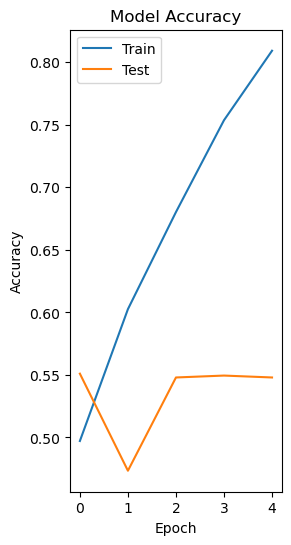

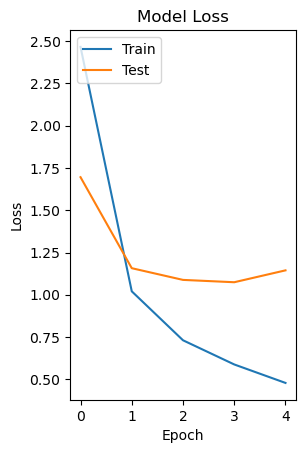

In [11]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Reducing Epochs

Reducing epochs from 5 to 3 to see if there is a difference in validation accuracy.

In [20]:
# Dropping to 3 epochs
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  

model = Model(inputs=base_model_vgg.input, outputs=predictions)

for layer in base_model_vgg.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_vgg, y_train_vgg, epochs=3, validation_split=0.2)

Epoch 1/3
83/83 [==============================] - 375s 5s/step - loss: 2.8869 - accuracy: 0.4930 - val_loss: 1.2721 - val_accuracy: 0.5632
Epoch 2/3
83/83 [==============================] - 402s 5s/step - loss: 1.0681 - accuracy: 0.5900 - val_loss: 1.0408 - val_accuracy: 0.5632
Epoch 3/3
83/83 [==============================] - 416s 5s/step - loss: 0.7762 - accuracy: 0.6650 - val_loss: 1.0197 - val_accuracy: 0.5540


In [21]:
test_loss, test_accuracy = model.evaluate(X_test_vgg, y_test_vgg)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

26/26 [==============================] - 95s 4s/step - loss: 0.9651 - accuracy: 0.5737
Test Loss: 0.9650813937187195
Test Accuracy: 0.5736905932426453


## Adjusting Learning Rate

Trying the learning rate used by Bose et. al (2021), which is 0.00001.

In [15]:
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  

model = Model(inputs=base_model_vgg.input, outputs=predictions)

for layer in base_model_vgg.layers:
    layer.trainable = False

# Configuring the Adam optimizer with a learning rate of 0.00001
adam_optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_vgg, y_train_vgg, epochs=5, validation_split=0.2)

Epoch 1/5
83/83 [==============================] - 335s 4s/step - loss: 3.4379 - accuracy: 0.3997 - val_loss: 1.8062 - val_accuracy: 0.4612
Epoch 2/5
83/83 [==============================] - 332s 4s/step - loss: 3.0359 - accuracy: 0.4168 - val_loss: 1.6153 - val_accuracy: 0.4886
Epoch 3/5
83/83 [==============================] - 333s 4s/step - loss: 2.7343 - accuracy: 0.4446 - val_loss: 1.5763 - val_accuracy: 0.5190
Epoch 4/5
83/83 [==============================] - 333s 4s/step - loss: 2.7527 - accuracy: 0.4503 - val_loss: 1.4887 - val_accuracy: 0.5266
Epoch 5/5
83/83 [==============================] - 332s 4s/step - loss: 2.5621 - accuracy: 0.4648 - val_loss: 1.4813 - val_accuracy: 0.5358


In [16]:
test_loss, test_accuracy = model.evaluate(X_test_vgg, y_test_vgg)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

26/26 [==============================] - 83s 3s/step - loss: 1.4410 - accuracy: 0.5262
Test Loss: 1.4410182237625122
Test Accuracy: 0.5261875987052917


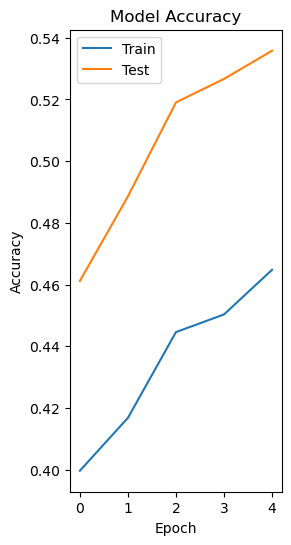

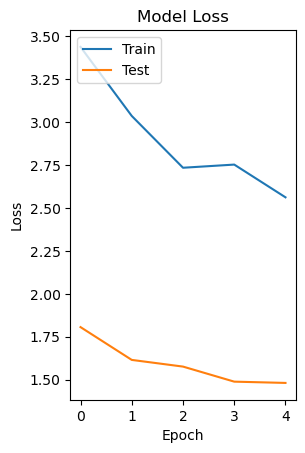

In [17]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Early Stopping

Trying Early Stopping to prevent overfitting but only at a patience of 3 and with 20 epochs due to computational and time limitations.

In [13]:
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  

model = Model(inputs=base_model_vgg.input, outputs=predictions)

for layer in base_model_vgg.layers:
    layer.trainable = False
    
# Adding Early stopping to stop training when there is no improvement in validation accuracy for more than 3 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_vgg, y_train_vgg, epochs=20, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
83/83 [==============================] - 343s 4s/step - loss: 2.7309 - accuracy: 0.4861 - val_loss: 1.3578 - val_accuracy: 0.5753
Epoch 2/20
83/83 [==============================] - 353s 4s/step - loss: 1.0058 - accuracy: 0.6075 - val_loss: 1.0275 - val_accuracy: 0.5784
Epoch 3/20
83/83 [==============================] - 361s 4s/step - loss: 0.7484 - accuracy: 0.6745 - val_loss: 1.0662 - val_accuracy: 0.5784
Epoch 4/20
83/83 [==============================] - 370s 4s/step - loss: 0.6363 - accuracy: 0.7309 - val_loss: 1.0254 - val_accuracy: 0.5738
Epoch 5/20
83/83 [==============================] - 354s 4s/step - loss: 0.5650 - accuracy: 0.7746 - val_loss: 1.0517 - val_accuracy: 0.5632


In [14]:
test_loss, test_accuracy = model.evaluate(X_test_vgg, y_test_vgg)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

26/26 [==============================] - 81s 3s/step - loss: 0.9727 - accuracy: 0.5968
Test Loss: 0.9727407693862915
Test Accuracy: 0.5968331098556519


## Adjusting Layers

Testing hyperparameters predefined by Wang and Lewis (2017) with VGG16 architecture.

In [10]:
# Adding custom layers 
x = base_model_vgg.output
x = Conv2D(512, (3, 3), padding='same')(x)  # First additional convolutional layer
x = BatchNormalization()(x)  # Adding a batch normalization layer
x = Activation('relu')(x)  # Adding a ReLU activation layer
x = Conv2D(512, (3, 3), padding='same')(x)  # Adding a second additional convolutional layer
x = BatchNormalization()(x)  # Adding a second batch normalization layer
x = Activation('relu')(x)  # Adding a second ReLU activation layer
x = Conv2D(len(label_encoder.classes_), (1, 1), padding='same')(x) 
x = GlobalAveragePooling2D()(x)  
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=base_model_vgg.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_vgg, y_train_vgg, epochs=3, validation_split=0.2)

Epoch 1/3
83/83 [==============================] - 1165s 14s/step - loss: 1.1011 - accuracy: 0.4819 - val_loss: 1.6968 - val_accuracy: 0.3988
Epoch 2/3
83/83 [==============================] - 1221s 15s/step - loss: 0.9838 - accuracy: 0.5280 - val_loss: 1.0296 - val_accuracy: 0.5342
Epoch 3/3
83/83 [==============================] - 1076s 13s/step - loss: 0.9787 - accuracy: 0.5246 - val_loss: 1.7907 - val_accuracy: 0.3196


In [11]:
test_loss, test_accuracy = model.evaluate(X_test_vgg, y_test_vgg)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

26/26 [==============================] - 88s 3s/step - loss: 1.7485 - accuracy: 0.3289
Test Loss: 1.748542308807373
Test Accuracy: 0.32886722683906555


## Adjusting Optimizers

Experimenting with the SGD Optimizer with momentum instead of Adam Optimizer

In [15]:
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=base_model_vgg.input, outputs=predictions)

for layer in base_model_vgg.layers:
    layer.trainable = False
    
# Using SGD optimizer instead of Adam
optimizer_sgd = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer_sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_vgg, y_train_vgg, epochs=5, validation_split=0.2)

Epoch 1/5
83/83 [==============================] - 358s 4s/step - loss: 2.9502 - accuracy: 0.4751 - val_loss: 1.0471 - val_accuracy: 0.5129
Epoch 2/5
83/83 [==============================] - 327s 4s/step - loss: 1.0405 - accuracy: 0.5348 - val_loss: 1.0634 - val_accuracy: 0.4855
Epoch 3/5
83/83 [==============================] - 328s 4s/step - loss: 0.9776 - accuracy: 0.5581 - val_loss: 0.9904 - val_accuracy: 0.5388
Epoch 4/5
83/83 [==============================] - 347s 4s/step - loss: 0.9572 - accuracy: 0.5653 - val_loss: 1.0253 - val_accuracy: 0.5556
Epoch 5/5
83/83 [==============================] - 370s 4s/step - loss: 0.9175 - accuracy: 0.5896 - val_loss: 0.9478 - val_accuracy: 0.5297


In [16]:
test_loss, test_accuracy = model.evaluate(X_test_vgg, y_test_vgg)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

26/26 [==============================] - 92s 4s/step - loss: 0.9608 - accuracy: 0.5664
Test Loss: 0.9607627987861633
Test Accuracy: 0.5663824677467346


# Checking Individual Predictions <a class="anchor" id="G"></a>

In [11]:
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  

model = Model(inputs=base_model_vgg.input, outputs=predictions)

for layer in base_model_vgg.layers:
    layer.trainable = False
    
# Adding Early stopping to stop training when there is no improvement in validation accuracy for more than 3 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_vgg, y_train_vgg, epochs=20, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
83/83 [==============================] - 363s 4s/step - loss: 2.7843 - accuracy: 0.4884 - val_loss: 1.6440 - val_accuracy: 0.5327
Epoch 2/20
83/83 [==============================] - 366s 4s/step - loss: 1.0943 - accuracy: 0.5877 - val_loss: 1.0226 - val_accuracy: 0.5738
Epoch 3/20
83/83 [==============================] - 376s 5s/step - loss: 0.7626 - accuracy: 0.6662 - val_loss: 1.0133 - val_accuracy: 0.5662
Epoch 4/20
83/83 [==============================] - 380s 5s/step - loss: 0.6319 - accuracy: 0.7305 - val_loss: 1.0829 - val_accuracy: 0.5556
Epoch 5/20
83/83 [==============================] - 429s 5s/step - loss: 0.5894 - accuracy: 0.7541 - val_loss: 1.0315 - val_accuracy: 0.5647


In [12]:
# Extracting predictions from the model to check what emotion the model predicts a random set of images has
predictions = model.predict(X_test_vgg)
predicted_labels_indices = np.argmax(predictions, axis=1)
predicted_emotion_categories = label_encoder.inverse_transform(predicted_labels_indices)

26/26 [==============================] - 100s 4s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


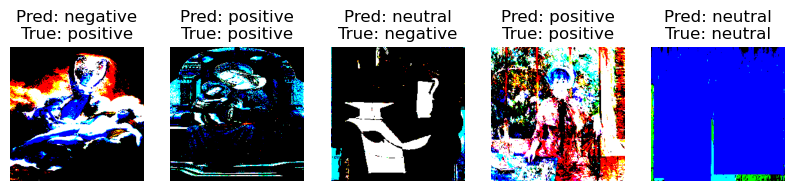

In [13]:
# Selecting a random set of images and their actual and predicted labels
indices = np.random.choice(range(len(X_test_vgg)), 5)
images = X_test_vgg[indices]
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions[indices], axis=1))
true_labels = label_encoder.inverse_transform(np.argmax(y_test_vgg[indices], axis=1))

# Plotting the images with their actual and predicted emotions
plt.figure(figsize=(10, 5))
for i, (image, pred, true) in enumerate(zip(images, predicted_labels, true_labels)):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.squeeze(image), cmap='gray')
    plt.title(f'Pred: {pred}\nTrue: {true}')
    plt.axis('off')
plt.show()

# Extra <a class="anchor" id="H"></a>

### Testing Xception

In [8]:
# Preprocessing images for Xception (with target size 299, 299)
def preprocess_image_for_xception(file_path):
    img = image.load_img(file_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_input_xception(img_array_expanded_dims)

preprocessed_images_xception = [preprocess_image_for_xception(os.path.join(image_directory, f'{row["ID"]}.jpg')) for index, row in df.iterrows()]
preprocessed_images_xception = np.vstack(preprocessed_images_xception)

In [9]:
X_train_xcp, X_test_xcp, y_train_xcp, y_test_xcp = train_test_split(preprocessed_images_xception, emotion_labels_categorical, test_size=0.2, random_state=42)

In [13]:
base_model_xcp = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = base_model_xcp.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  

model = Model(inputs=base_model_xcp.input, outputs=predictions)

for layer in base_model_xcp.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_xcp, y_train_xcp, epochs=5, validation_split=0.2)


Epoch 1/5
83/83 [==============================] - 285s 3s/step - loss: 0.9493 - accuracy: 0.5413 - val_loss: 0.9144 - val_accuracy: 0.5693
Epoch 2/5
83/83 [==============================] - 281s 3s/step - loss: 0.7926 - accuracy: 0.6391 - val_loss: 0.9016 - val_accuracy: 0.5723
Epoch 3/5
83/83 [==============================] - 276s 3s/step - loss: 0.7081 - accuracy: 0.6943 - val_loss: 0.9579 - val_accuracy: 0.5388
Epoch 4/5
83/83 [==============================] - 269s 3s/step - loss: 0.6253 - accuracy: 0.7370 - val_loss: 1.0587 - val_accuracy: 0.5616
Epoch 5/5
83/83 [==============================] - 286s 3s/step - loss: 0.5151 - accuracy: 0.7884 - val_loss: 1.0810 - val_accuracy: 0.5251


In [14]:
test_loss, test_accuracy = model.evaluate(X_test_xcp, y_test_xcp)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

26/26 [==============================] - 71s 3s/step - loss: 1.1129 - accuracy: 0.4945
Test Loss: 1.1128783226013184
Test Accuracy: 0.49451887607574463


### Testing ResNet50

In [33]:
base_model_res = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_res.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  

model = Model(inputs=base_model_res.input, outputs=predictions)

for layer in base_model_res.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ResNet uses the same preprocessing as VGG16, so the same test and training sets were used
model.fit(X_train_vgg, y_train_vgg, epochs=5, validation_split=0.2)

Epoch 1/5
83/83 [==============================] - 209s 2s/step - loss: 1.2481 - accuracy: 0.5421 - val_loss: 0.9262 - val_accuracy: 0.5540
Epoch 2/5
83/83 [==============================] - 189s 2s/step - loss: 0.7957 - accuracy: 0.6426 - val_loss: 0.9091 - val_accuracy: 0.5830
Epoch 3/5
83/83 [==============================] - 187s 2s/step - loss: 0.7122 - accuracy: 0.6844 - val_loss: 0.9903 - val_accuracy: 0.5647
Epoch 4/5
83/83 [==============================] - 188s 2s/step - loss: 0.6293 - accuracy: 0.7267 - val_loss: 1.0476 - val_accuracy: 0.5358
Epoch 5/5
83/83 [==============================] - 186s 2s/step - loss: 0.5394 - accuracy: 0.7796 - val_loss: 1.1274 - val_accuracy: 0.5236


In [34]:
test_loss, test_accuracy = model.evaluate(X_test_vgg, y_test_vgg)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

26/26 [==============================] - 47s 2s/step - loss: 1.0735 - accuracy: 0.5371
Test Loss: 1.0735477209091187
Test Accuracy: 0.5371498465538025


# References

Bose, D., et al. (2021) 'Understanding of Emotion Perception from Art', arXiv. Available at: https://arxiv.org/abs/2110.06486.

OpenAI ChatGPT (2023) 'Xception Model Adaptation'. Available at: https://chat.openai.com/share/25927c31-6506-42a2-8870-cf979d0af306.

OpenAI ChatGPT (2023) 'Display Custom Image Paths'. Available at: https://chat.openai.com/share/0c2dcb26-9cd7-4ecf-afc9-c380bccff58f. 

Wang, Y. and Lewis, M. (2017) 'ArtTalk: Labeling Images with Thematic and Emotional Content'. Available at: https://cs231n.stanford.edu/reports/2017/pdfs/414.pdf.